# TL; DR:
- least_squares() beats minimize() in speed and reproducibility
- Trying to minimize futile cycles by penalizing all flux does not work well
  - The optimizer does not always converge, particularly with minimize()
  - When it does converge, the constraint introduces artifacts into the solution
- An alternative approach to break futile cycles seems to work well

Changes were needed to this notebook to reproduce its behavior before the branch 'futile' and revision 39da4196528af413112ecf304a2dea070d023180, implementing the very changes it suggests.

In [1]:
import projectpath

from typing import Union, Iterable

import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
from scipy.sparse import csr_matrix

from kb import kb
from model.reaction_network import ReactionNetwork
from model.core import KbEntry, Molecule, Reaction, Pathway
from sim import fba_gd

KB = kb.configure_kb()

jax.config.update('jax_enable_x64', True)

def labels(entries: Union[KbEntry, Iterable[KbEntry]]):
    if isinstance(entries, KbEntry):
        return entries.shorthand or entries.id
    else:
        return [entry.shorthand or entry.id for entry in entries]

# Setup: PTS + glycolysis + PPP; objectives from [R5P, E4P, PEP, acCoA]

In [2]:
glycolysis = KB.find(KB.pathways, 'glycolysis')[0]
ppp = KB.find(KB.pathways, 'pentose phosphate')[0]
pts = KB.get(KB.reactions, 'pts.glc')

r5p = KB.get(KB.compounds, 'Rib.D.5P')
e4p = KB.get(KB.compounds, 'Ery.D.4P')
pep = KB.get(KB.compounds, 'pep')
pyr = KB.get(KB.compounds, 'pyr')
acCoA = KB.get(KB.compounds, 'accoa')

concs = {KB.get(KB.compounds, met_id): conc for met_id, conc in [
    ('accoa', 0.61),
    ('adp', 0.55),
    ('amp', 0.28),
    ('atp', 9.6),
    ('co2', 0.01),
    ('coa', 1.4),
    ('h+', 1e-7),
    ('h2o', 55500.),
    ('nad.ox', 2.6),
    ('nad.red', 0.083),
    ('nadp.ox', 0.0021),
    ('nadp.red', 0.12),
    ('pep', 0.18),
    ('pyr', 0.1),  # guess
    ('pi', 10.),  # guess
    ('Rib.D.5P', 0.8),  # guess
    ('Ery.D.4P', 0.8),  # guess    
    ('Glc.D.ext', 10.),  # arbitrary
]}

network = ReactionNetwork([pts] + glycolysis.steps + ppp.steps)
boundaries = concs.keys()
intermediates = [met for met in network.reactants() if met not in boundaries]

# Existing Code

## Straight glycolysis to acCoA

In [3]:
import time

# Reconstructing existing code, before 39da4196528af413112ecf304a2dea070d023180
def l_pt5(residual):
    return jnp.sum(jnp.sqrt(jnp.abs(residual)))

def l2(residual):
    return jnp.sum(jnp.square(residual))

class LegacyObjective(fba_gd.Objective):
    def __init__(self, objective, aggfun=l2):
        self.objective = objective
        self.weight = objective.weight
        self.aggfun = aggfun

    def update_params(self, params):
        self.objective.update_params(params)

    def params(self):
        return self.objective.params()

    def residual(self, velocities, dmdt, params):
        return self.objective.residual(velocities, dmdt, params)

    def loss(self, velocities, dmdt, params):
        return self.objective.weight * self.aggfun(self.objective.residual(velocities, dmdt, params))

class LegacyFbaGd:
    def __init__(self, network, intermediates, objectives, w_fitness=1e4, w_sparsity=1e-4):
        self.network = network
        self.objectives = {
            'steady-state': LegacyObjective(fba_gd.SteadyStateObjective(network, intermediates, weight=w_fitness)),
            'irreversibility': LegacyObjective(fba_gd.IrreversibilityObjective(network, weight=w_fitness)),
            'sparsity': LegacyObjective(fba_gd.VelocityObjective(network, {r: 0 for r in network.reactions()}, weight=w_sparsity), aggfun=l_pt5),
        }
        self.objectives.update(objectives)

        def loss(v, *params):
            dmdt = self.network.s_matrix @ v
            return sum(objective.loss(v, dmdt, p) for objective, p in zip(self.objectives.values(), params))

        # Cache the jitted loss and jacobian functions
        self._loss_jit = jax.jit(loss)
        self._loss_jac = jax.jit(jax.jacfwd(loss))

    def update_params(self, updates):
        for name, params in updates.items():
            self.objectives[name].update_params(params)

    def solve(self, v0=None, seed=None, **kw_args):
        if v0 is None:
            if seed is None:
                seed = jax.random.PRNGKey(int(time.time() * 1000))
            v0 = jax.random.normal(seed, self.network.shape[1:])

        params = tuple(objective.params() for objective in self.objectives.values())
        soln = scipy.optimize.minimize(fun=self._loss_jit, args=params, x0=v0, jac=self._loss_jac, **kw_args)

        dmdt = self.network.s_matrix @ soln.x
        return fba_gd.FbaResult(v0=v0,
                                velocities=soln.x,
                                dmdt=dmdt,
                                fit=sum(float(self.objectives[name].loss(soln.x, dmdt, None))
                                        for name in ['steady-state', 'irreversibility']))

fba = LegacyFbaGd(
    network,
    intermediates,
    {
        'drivers': LegacyObjective(fba_gd.ProductionObjective(network, {acCoA: 0.06, pep: 0., pyr:  0., r5p: 0., e4p: 0.})),
    }
)
soln = fba.solve()

In [4]:
for m, dmdt in network.reactant_values(soln.dmdt).items():
    print(f'{labels(m):>12s}: {dmdt:7.4f}')

   Glc.D.ext: -0.0006
         PEP: -0.0027
    Glc.D.6P: -0.0000
         pyr: -0.0027
    Fru.D.6P: -0.0000
         ATP: -0.3915
         ADP: -1.3298
 Fru.D.bis16:  0.0000
          H+:  1.9745
         H2O: -2.0035
          Pi:  2.1207
         GAP: -0.0000
        DHAP:  0.0000
         NAD: -0.1016
         DPG:  0.0000
        NADH:  0.1016
         3PG: -0.0000
         2PG:  0.0000
         AMP:  1.7213
         CoA: -0.0535
       acCoA:  0.0535
         CO2: -0.0638
    Rib.D.5P: -0.0027
    Rul.D.5P: -0.0000
    Sed.D.7P: -0.0000
    Xul.D.5P:  0.0000
       6PGDL: -0.0000
         6PG: -0.0000
        NADP:  0.2345
       NADPH: -0.2345
    Ery.D.4P: -0.0024


In [5]:
for r, v in network.reaction_values(soln.velocities).items():
    print(f"    ('{r.id}', {v:7.4f}),  # {r.shorthand or r.name}")

    ('pts.glc',  0.0006),  # GlcPTS
    ('pgi',  0.1179),  # PGI
    ('pfk',  0.4898),  # PFK
    ('fbp',  0.4475),  # FBP
    ('fba',  0.0423),  # FBA
    ('tpi', -0.0423),  # TPI
    ('gapdh',  0.0481),  # GAPDH
    ('pgk', -0.0481),  # PGK
    ('gpm.indep', -0.0481),  # GPMM
    ('eno',  0.0481),  # ENO
    ('pyk', -1.7715),  # PYK
    ('pps',  1.7213),  # PPS
    ('pdh',  0.0535),  # PDH
    ('r5pi',  0.0417),  # R5PI
    ('tkt.c5c5',  0.0390),  # TKT1
    ('rpe', -0.0756),  # RPE
    ('pglase', -0.1173),  # PGLase
    ('pgldh', -0.1173),  # PGLDH
    ('tal', -0.0390),  # TALA
    ('tkt.c5c4', -0.0366),  # TKT2
    ('g6pdh', -0.1173),  # G6PDH


Not a compelling solution. What if we manufacture the known 'best' (or at least intended) solution?

In [6]:
optimal = {KB.get(KB.reactions, rxn_id): v for rxn_id, v in [
    ('pts.glc',  0.03),
    ('pgi', 0.03),
    ('pfk',  0.03),
    ('fbp',  0.),
    ('fba', 0.03),
    ('tpi',  -0.03),
    ('gapdh',  0.06),
    ('pgk', -0.06),
    ('gpm.indep', -0.06),
    ('eno',  0.06),
    ('pyk',  -0.03),
    ('pps',  0.),
    ('pdh',  0.06),
    ('r5pi', 0.),
    ('tkt.c5c5', 0.),
    ('rpe',  0.),
    ('pglase',  0.),
    ('pgldh',  0.),
    ('tal',  0.),
    ('tkt.c5c4',  0.),
    ('g6pdh',  0.),
]}
optimal_array = network.reaction_vector(optimal)
dmdt = network.s_matrix @ optimal_array

for key, obj in fba.objectives.items():
    print(key, obj.residual(optimal_array, dmdt, obj.params()))

steady-state [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
irreversibility [0. 0. 0. 0. 0.]
sparsity [ 0.03  0.03  0.03  0.    0.03 -0.03  0.06 -0.06 -0.06  0.06 -0.03  0.
  0.06  0.    0.    0.    0.    0.    0.    0.    0.  ]
drivers [0. 0. 0. 0. 0.]


In [7]:
optimal_array.shape

(21,)

In [8]:
# jiggle = 0.00001 * jax.random.normal(jax.random.PRNGKey(0), optimal_array.shape)
jiggle = np.array([[1e-4] + [0] * 20])
soln = fba.solve(v0=optimal_array + jiggle, options={'disp': True})
print(soln.velocities, soln.velocities - optimal_array)
for key, obj in fba.objectives.items():
    print(key, obj.residual(soln.velocities, soln.dmdt, obj.params()))

         Current function value: 0.000326
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
[ 0.0301  0.03    0.03    0.      0.03   -0.03    0.06   -0.06   -0.06
  0.06   -0.03    0.      0.06    0.      0.      0.      0.      0.
  0.      0.      0.    ] [1.e-04 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00
 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00
 0.e+00]
steady-state [1.e-04 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00
 0.e+00 0.e+00 0.e+00]
irreversibility [0. 0. 0. 0. 0.]
sparsity [ 0.0301  0.03    0.03    0.      0.03   -0.03    0.06   -0.06   -0.06
  0.06   -0.03    0.      0.06    0.      0.      0.      0.      0.
  0.      0.      0.    ]
drivers [ 0.e+00 -1.e-04  1.e-04  0.e+00  0.e+00]


With minimize() and the above objective:
- jiggle = 0 ==> Warning: NaN result encountered.
- jiggle = _any_ non-zero, even very small ==> Warning: Desired error not necessarily achieved due to precision loss.

**Not** working as intended

## Try it in μM to give more breathing room on the bottom

In [9]:
fba.update_params({'drivers': {acCoA: 60.}})
jiggle = 1e-6 * jax.random.normal(jax.random.PRNGKey(0), optimal_array.shape)
soln = fba.solve(v0=optimal_array*1000 + jiggle, options={'disp': True})
print(soln.velocities, soln.velocities - optimal_array*1000)
for key, obj in fba.objectives.items():
    print(key, obj.residual(soln.velocities, soln.dmdt, obj.params()))

         Current function value: 0.007160
         Iterations: 4
         Function evaluations: 64
         Gradient evaluations: 56
[ 2.99999999e+01  2.99999997e+01  3.00000004e+01 -9.96902408e-07
  3.00000001e+01 -3.00000005e+01  5.99999997e+01 -6.00000001e+01
 -5.99999992e+01  6.00000002e+01 -2.99999988e+01  5.46444976e-07
  6.00000014e+01  1.15028206e-08 -7.08899396e-08  3.56060595e-07
 -3.60925550e-07 -9.21740116e-07 -1.17474740e-06  4.19498256e-10
 -5.44813269e-07] [-7.45090674e-08 -2.64279787e-07  3.82863188e-07 -9.96902408e-07
  1.47420430e-07 -4.88234676e-07 -2.81621091e-07 -8.97009329e-08
  7.64537162e-07  1.72420776e-07  1.21294777e-06  5.46444976e-07
  1.44711706e-06  1.15028206e-08 -7.08899396e-08  3.56060595e-07
 -3.60925550e-07 -9.21740116e-07 -1.17474740e-06  4.19498256e-10
 -5.44813269e-07]
steady-state [ 7.34583989e-07 -2.81837329e-06  1.23234517e-06  2.16333304e-06
 -3.40814246e-07 -3.71322024e-07  8.54238095e-07 -9.36957939e-07
 -1.26629789e-06  1.24563734e-06  2.84

Same result. Comforting, I guess...

## Still using scipy.optimize.minimize, but remove sparsity objective (which is on a very different scale)

In [10]:
fba = LegacyFbaGd(
    network,
    intermediates,
    {'drivers': LegacyObjective(fba_gd.ProductionObjective(network, {acCoA: 0.06, pep: 0., pyr:  0., r5p: 0., e4p: 0.})),},
    w_sparsity=0.,
)
jiggle = 1e-4 * jax.random.normal(jax.random.PRNGKey(0), optimal_array.shape)
soln = fba.solve(v0=optimal_array + jiggle, options={'disp': True})
print(soln.velocities, soln.velocities - optimal_array)
for r, v in network.reaction_values(soln.velocities).items():
    print(f"{r.id:>20}: {v:8.5f}")

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 23
         Function evaluations: 38
         Gradient evaluations: 38
[ 3.00026975e-02  2.99830434e-02  3.00464705e-02  5.04443813e-05
  2.99960263e-02 -2.99960262e-02  5.99985114e-02 -5.99985113e-02
 -5.99985114e-02  5.99985115e-02 -3.00189503e-02  2.26691742e-05
  5.99994887e-02 -6.67123994e-06 -6.52433949e-06  1.29830516e-05
  1.96541908e-05  1.96541841e-05  6.52421810e-06  6.45862714e-06
  1.96541254e-05] [ 2.69752801e-06 -1.69566249e-05  4.64705044e-05  5.04443813e-05
 -3.97374100e-06  3.97380921e-06 -1.48856967e-06  1.48871002e-06
  1.48860756e-06 -1.48854250e-06 -1.89503477e-05  2.26691742e-05
 -5.11283013e-07 -6.67123994e-06 -6.52433949e-06  1.29830516e-05
  1.96541908e-05  1.96541841e-05  6.52421810e-06  6.45862714e-06
  1.96541254e-05]
             pts.glc:  0.03000
                 pgi:  0.02998
                 pfk:  0.03005
                 fbp:  0.00005
                 f

### Manually break futile cycles

In [11]:
fba = LegacyFbaGd(
    network,
    intermediates,
    {
        'drivers': LegacyObjective(fba_gd.ProductionObjective(network, {acCoA: 0.06, pep: 0., pyr:  0., r5p: 0., e4p: 0.}, weight=100.)),
        'non-futility': LegacyObjective(fba_gd.VelocityObjective(network, {
            KB.get(KB.reactions, 'fbp'): 0.,
            KB.get(KB.reactions, 'pps'): 0.,
        })),
    },
    w_sparsity=0.,
)
jiggle = 1e-2 * jax.random.normal(jax.random.PRNGKey(0), optimal_array.shape)
soln = fba.solve(v0=optimal_array + jiggle, options={'disp': True})
print(soln.velocities)
print(np.sum(np.square(soln.velocities - optimal_array)))
for r, v in network.reaction_values(soln.velocities).items():
    print(f"{r.id:>20}: {v:8.5f}")

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 53
         Function evaluations: 91
         Gradient evaluations: 91
[ 3.02870793e-02  2.85644768e-02  2.97129603e-02  7.91398382e-08
  2.97128813e-02 -2.97128812e-02  5.99999663e-02 -5.99999662e-02
 -5.99999661e-02  5.99999664e-02 -2.97129058e-02  8.53532326e-09
  5.99999886e-02 -5.74198205e-04 -5.74201157e-04  1.14840458e-03
  1.72260263e-03  1.72260280e-03  5.74200934e-04  5.74203430e-04
  1.72260263e-03]
1.4012570535181616e-05
             pts.glc:  0.03029
                 pgi:  0.02856
                 pfk:  0.02971
                 fbp:  0.00000
                 fba:  0.02971
                 tpi: -0.02971
               gapdh:  0.06000
                 pgk: -0.06000
           gpm.indep: -0.06000
                 eno:  0.06000
                 pyk: -0.02971
                 pps:  0.00000
                 pdh:  0.06000
                r5pi: -0.00057
            tkt.c5c5: -0.000

At least it appears to consistently find a solution. Doesn't knock my socks off though.

- Wait, this could be legitimate. We have set an objective for acCoA production, and that is being met exactly (PDH velocity = 0.06000). Some unexpected flux is going through PPP, spending a little extra G6P and getting some NADPH + CO2, but none of our objectives discourage that. If we force 1 G6P => 2 acCoA, or alternatively NADPH = 0, it could consistently find the same (optimal) solution.

In [12]:
fba = LegacyFbaGd(
    network,
    intermediates,
    {
        'drivers': LegacyObjective(
            fba_gd.ProductionObjective(network, {acCoA: 0.06, pep: 0., pyr:  0., r5p: 0., e4p: 0., KB.get(KB.compounds, 'Glc.D.ext'): -0.03})),
        'non-futility': LegacyObjective(fba_gd.VelocityObjective(network, {
            KB.get(KB.reactions, 'fbp'): 0.,
            KB.get(KB.reactions, 'pps'): 0.,
        })),
    },
    w_sparsity=0.,
)
jiggle = 1e-1 * jax.random.normal(jax.random.PRNGKey(0), optimal_array.shape)
soln = fba.solve(v0=optimal_array + jiggle, options={'disp': True})
print(np.sum(np.square(soln.velocities - optimal_array)))
print()
for r, v in network.reaction_values(soln.velocities).items():
    print(f"{r.id:>20}: {v:8.5f}")

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 94
         Function evaluations: 194
         Gradient evaluations: 194
1.6971035294198116e-13

             pts.glc:  0.03000
                 pgi:  0.03000
                 pfk:  0.03000
                 fbp:  0.00000
                 fba:  0.03000
                 tpi: -0.03000
               gapdh:  0.06000
                 pgk: -0.06000
           gpm.indep: -0.06000
                 eno:  0.06000
                 pyk: -0.03000
                 pps:  0.00000
                 pdh:  0.06000
                r5pi:  0.00000
            tkt.c5c5:  0.00000
                 rpe: -0.00000
              pglase: -0.00000
               pgldh: -0.00000
                 tal: -0.00000
            tkt.c5c4: -0.00000
               g6pdh: -0.00000


Ok, that's viable

## Using scipy.optimize.least_squares, with catenated residual vectors

In [13]:
objectives = {
    'steady-state': fba_gd.SteadyStateObjective(network, intermediates, weight=1e4),
    'irreversibility': fba_gd.IrreversibilityObjective(network, weight=1e4),
    'drivers': fba_gd.ProductionObjective(network, {acCoA: 0.06, pep: 0., pyr:  0., r5p: 0., e4p: 0., KB.get(KB.compounds, 'Glc.D.ext'): -0.03}),
    'non-futility': fba_gd.VelocityObjective(network, {KB.get(KB.reactions, 'fbp'): 0., KB.get(KB.reactions, 'pps'): 0.}),
}

def residual(v, *params):
    dmdt = network.s_matrix @ v
    return jnp.concatenate([objective.residual(v, dmdt, p) * np.sqrt(objective.weight)
                            for objective, p in zip(objectives.values(), params)])

# Cache the jitted loss and jacobian functions
_loss_jit = jax.jit(residual)
_loss_jac = jax.jit(jax.jacfwd(residual))

jiggle = 1e-1 * jax.random.normal(jax.random.PRNGKey(0), optimal_array.shape)
v0=optimal_array + jiggle

params = tuple(objective.params() for objective in objectives.values())
soln = scipy.optimize.least_squares(fun=_loss_jit, args=params, x0=v0, jac=_loss_jac)
print(soln.message)

dmdt = network.s_matrix @ soln.x
fba_soln = fba_gd.FbaResult(v0=np.asarray(v0),
                            velocities=np.asarray(soln.x),
                            dmdt=np.asarray(dmdt),
                            fit=sum(np.sum(np.square(objectives[name].loss(soln.x, dmdt, None))) for name in ['steady-state', 'irreversibility']))
print(np.sum(np.square(fba_soln.velocities - optimal_array)))
print()
for r, v in network.reaction_values(fba_soln.velocities).items():
    print(f"{r.id:>20}: {v:8.5f}")


`gtol` termination condition is satisfied.
7.814925622663327e-30

             pts.glc:  0.03000
                 pgi:  0.03000
                 pfk:  0.03000
                 fbp: -0.00000
                 fba:  0.03000
                 tpi: -0.03000
               gapdh:  0.06000
                 pgk: -0.06000
           gpm.indep: -0.06000
                 eno:  0.06000
                 pyk: -0.03000
                 pps: -0.00000
                 pdh:  0.06000
                r5pi:  0.00000
            tkt.c5c5: -0.00000
                 rpe:  0.00000
              pglase:  0.00000
               pgldh:  0.00000
                 tal:  0.00000
            tkt.c5c4:  0.00000
               g6pdh:  0.00000


# Methodical comparison over 100 trials

In [14]:
v0 = jax.random.normal(jax.random.PRNGKey(0), (100, network.shape[1]))

### with scipy.optimize.minimize, improved as above

In [15]:
fba = LegacyFbaGd(
    network,
    intermediates,
    {
        'drivers': LegacyObjective(
            fba_gd.ProductionObjective(network, {acCoA: 0.06, pep: 0., pyr:  0., r5p: 0., e4p: 0., KB.get(KB.compounds, 'Glc.D.ext'): -0.03})),
        'non-futility': LegacyObjective(fba_gd.VelocityObjective(network, {KB.get(KB.reactions, 'fbp'): 0., KB.get(KB.reactions, 'pps'): 0.})),
    },
    w_sparsity=0.,
)

In [16]:
%%time
results_a = [fba.solve(v0=trial).velocities for trial in v0]

CPU times: user 3.96 s, sys: 223 µs, total: 3.96 s
Wall time: 3.95 s


### same problem with scipy.optimize.least_squares

In [17]:
objectives = {
    'steady-state': fba_gd.SteadyStateObjective(network, intermediates, weight=1e4),
    'irreversibility': fba_gd.IrreversibilityObjective(network, weight=1e4),
    'drivers': fba_gd.ProductionObjective(network, {acCoA: 0.06, pep: 0., pyr:  0., r5p: 0., e4p: 0., KB.get(KB.compounds, 'Glc.D.ext'): -0.03}),
    'non-futility': fba_gd.VelocityObjective(network, {KB.get(KB.reactions, 'fbp'): 0., KB.get(KB.reactions, 'pps'): 0.}),
}

def residual(v, *params):
    dmdt = network.s_matrix @ v
    return jnp.concatenate([objective.residual(v, dmdt, p) * np.sqrt(objective.weight)
                            for objective, p in zip(objectives.values(), params)])

_loss_jit = jax.jit(residual)
_loss_jac = jax.jit(jax.jacfwd(residual))

params = tuple(objective.params() for objective in objectives.values())

In [18]:
%%time
results_b = [scipy.optimize.least_squares(fun=_loss_jit, args=params, x0=trial, jac=_loss_jac).x for trial in v0]

CPU times: user 519 ms, sys: 6.94 ms, total: 526 ms
Wall time: 522 ms


So, conservatively ~8x faster

In [19]:
active = np.nonzero(optimal_array)
active_labels = np.array(labels(network.reactions()))[active]
' -> '.join(active_labels)

'GlcPTS -> PGI -> PFK -> FBA -> TPI -> GAPDH -> PGK -> GPMM -> ENO -> PYK -> PDH'

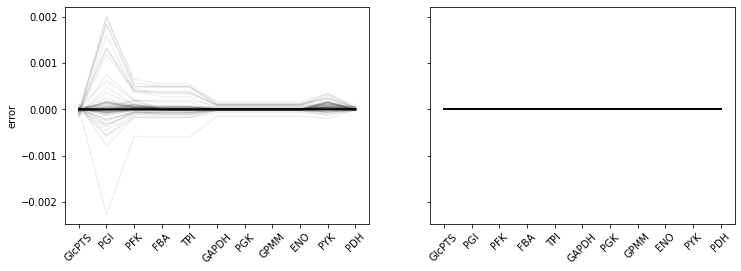

In [24]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4), sharey='all')
for result in results_a:
    ax[0].plot(np.log(result[active] / optimal_array[active]), color='#00000010')
for result in results_b:
    ax[1].plot(np.log(result[active] / optimal_array[active]), color='#00000010')

ax[0].set_ylabel('error')
ax[0].set_xticks(range(len(active_labels)), active_labels, rotation=45)
ax[1].set_xticks(range(len(active_labels)), active_labels, rotation=45)
plt.show()

And waaay more consistent

In [25]:
rms_error_a = [np.sqrt(np.mean(np.square(result - optimal_array))) for result in results_a]
print(f'minimize() rms error vs optimal: {np.mean(rms_error_a):.2e}')
rms_error_b = [np.sqrt(np.mean(np.square(result - optimal_array))) for result in results_b]
print(f'least_squares() rms error vs optimal: {np.mean(rms_error_b):.2e}')

minimize() rms error vs optimal: 4.12e-06
least_squares() rms error vs optimal: 6.49e-15


### One more time, with previous sparsity objective but using least_squares

In [26]:
objectives = {
    'steady-state': LegacyObjective(fba_gd.SteadyStateObjective(network, intermediates, weight=1e4)),
    'irreversibility': LegacyObjective(fba_gd.IrreversibilityObjective(network, weight=1e4)),
    'drivers': LegacyObjective(
        fba_gd.ProductionObjective(network, {acCoA: 0.06, pep: 0., pyr:  0., r5p: 0., e4p: 0., KB.get(KB.compounds, 'Glc.D.ext'): -0.03})),
    # 'non-futility': fba_gd.VelocityObjective(network, {KB.get(KB.reactions, 'fbp'): 0., KB.get(KB.reactions, 'pps'): 0.}),
    'sparsity': LegacyObjective(fba_gd.VelocityObjective(network, {rxn: 0.0 for rxn in network.reactions()}, weight=1e-4), aggfun=l_pt5)
}

def residual(v, *params):
    dmdt = network.s_matrix @ v
    return jnp.concatenate([objective.residual(v, dmdt, p) * np.sqrt(objective.weight)
                            for objective, p in zip(objectives.values(), params)])

_loss_jit = jax.jit(residual)
_loss_jac = jax.jit(jax.jacfwd(residual))

params = tuple(objective.params() for objective in objectives.values())

In [27]:
%%time
results_c = [scipy.optimize.least_squares(fun=_loss_jit, args=params, x0=trial, jac=_loss_jac).x for trial in v0]

CPU times: user 842 ms, sys: 151 µs, total: 842 ms
Wall time: 837 ms


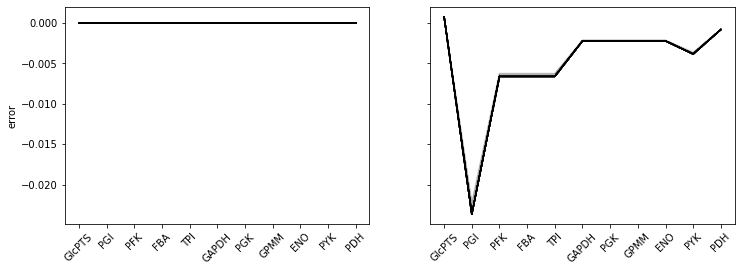

least_squares() with sparsity objective, rms error vs optimal: 3.61e-04


In [28]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4), sharey='all')
for result in results_b:
    ax[0].plot(np.log(result[active] / optimal_array[active]), color='#00000010')
for result in results_c:
    ax[1].plot(np.log(result[active] / optimal_array[active]), color='#00000010')

ax[0].set_ylabel('error')
ax[0].set_xticks(range(len(active_labels)), active_labels, rotation=45)
ax[1].set_xticks(range(len(active_labels)), active_labels, rotation=45)
plt.show()

rms_error_c = [np.sqrt(np.mean(np.square(result - optimal_array))) for result in results_c]
print(f'least_squares() with sparsity objective, rms error vs optimal: {np.mean(rms_error_c):.2e}')

Unexpected: not just worse, but consistently incorrect, or at least not the intended optimal solution.

In [29]:
soln = scipy.optimize.least_squares(fun=_loss_jit, args=params, x0=v0[0], jac=_loss_jac, verbose=2)
dmdt = network.s_matrix @ soln.x
print(f"Fit: {sum(float(objectives[name].loss(soln.x, dmdt, None)) for name in ['steady-state', 'irreversibility'])}")
print(soln.x[active] / optimal_array[active])

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         3.1521e+05                                    8.93e+04    
       1              2         2.0837e+02      3.15e+05       4.86e+00       2.04e+03    
       2              3         4.5913e-04      2.08e+02       2.92e-01       3.05e-02    
       3              4         1.1662e-06      4.58e-04       3.78e-01       8.10e-13    
`gtol` termination condition is satisfied.
Function evaluations 4, initial cost 3.1521e+05, final cost 1.1662e-06, first-order optimality 8.10e-13.
Fit: 7.63471524900238e-13
[1.0007293  0.97661217 0.99339939 0.99339949 0.99339954 0.99775893
 0.99775897 0.99775902 0.99775907 0.99614976 0.99916981]


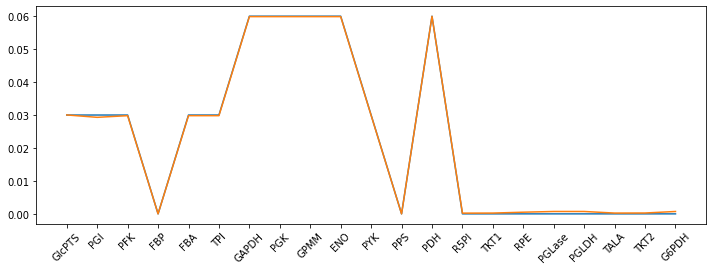

In [30]:
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(np.abs(optimal_array), label='expected')
ax.plot(np.abs(soln.x), label='found')
ax.set_xticks(range(network.shape[1]), labels(network.reactions()), rotation=45)
plt.show()


**Narrative**: 
- We disincentivize _all_ non-zero flux, with an L2 loss funciton.
- The system can reduce flux through PGI by bypassing via PPP.
- The beneift of reducing (squared) PGI flux compensates for the penalty of increased Glc consumption and/or reduced acCoA production.
- This is an uninteded artifact of the method we use to minimize futile cycles. An alternative approach is better.

### Build an objective explicitly to minimize flux in a futile cycle
- Added benefit: optimality drives the residual to zero instead of minimizing a positive number

In [31]:
class ExclusionObjective(fba_gd.Objective):
    """Incentivizes mutually exclusive fluxes within a set of reactions."""

    def __init__(self, network, reactions, weight=1.0):
        super().__init__(weight=weight)
        self.network = network
        self.indices = np.array([network.reaction_index(rxn) for rxn in reactions], dtype=np.int32)

    def residual(self, velocities, dmdt, params=None):
        return jnp.prod(velocities[self.indices], keepdims=True)


In [32]:
objectives = {
    'steady-state': LegacyObjective(fba_gd.SteadyStateObjective(network, intermediates, weight=1e4)),
    'irreversibility': LegacyObjective(fba_gd.IrreversibilityObjective(network, weight=1e4)),
    'drivers': LegacyObjective(
        fba_gd.ProductionObjective(network, {acCoA: 0.06, pep: 0., pyr:  0., r5p: 0., e4p: 0., KB.get(KB.compounds, 'Glc.D.ext'): -0.03})),
    'non-futility-fbp': LegacyObjective(ExclusionObjective(network, [KB.get(KB.reactions, 'fbp'), KB.get(KB.reactions, 'pfk')])),
    'non-futility-pps': LegacyObjective(ExclusionObjective(network, [KB.get(KB.reactions, 'pps'), KB.get(KB.reactions, 'pyk')])),
}

def residual(v, *params):
    dmdt = network.s_matrix @ v
    return jnp.concatenate([objective.residual(v, dmdt, p) * np.sqrt(objective.weight)
                            for objective, p in zip(objectives.values(), params)])

_loss_jit = jax.jit(residual)
_loss_jac = jax.jit(jax.jacfwd(residual))

params = tuple(objective.params() for objective in objectives.values())

In [33]:
%%time
results_d = [scipy.optimize.least_squares(fun=_loss_jit, args=params, x0=trial, jac=_loss_jac).x for trial in v0]

CPU times: user 759 ms, sys: 3.57 ms, total: 763 ms
Wall time: 757 ms


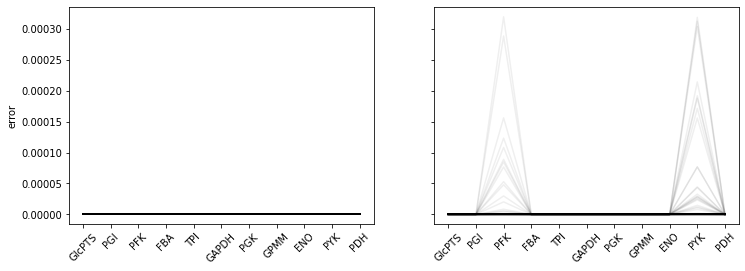

least_squares() with exclusion objective, rms error vs optimal: 3.45e-07


In [34]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4), sharey='all')
for result in results_b:
    ax[0].plot(np.log(result[active] / optimal_array[active]), color='#00000010')
for result in results_d:
    ax[1].plot(np.log(result[active] / optimal_array[active]), color='#00000010')

ax[0].set_ylabel('error')
ax[0].set_xticks(range(len(active_labels)), active_labels, rotation=45)
ax[1].set_xticks(range(len(active_labels)), active_labels, rotation=45)
plt.show()

rms_error_d = [np.sqrt(np.mean(np.square(result - optimal_array))) for result in results_d]
print(f'least_squares() with exclusion objective, rms error vs optimal: {np.mean(rms_error_d):.2e}')

- Better than sparsity, not as good as a pure zero velocity objective. 
- It does at least specifically target futile cycles.

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         3.1521e+05                                    8.93e+04    
       1              2         9.6807e+00      3.15e+05       4.86e+00       4.95e+02    
       2              3         4.8306e-04      9.68e+00       1.95e-01       3.00e-02    
       3              4         2.0721e-06      4.81e-04       3.96e-01       1.27e-04    
       4              5         1.0501e-07      1.97e-06       3.03e-02       1.89e-05    
       5              6         2.9523e-09      1.02e-07       1.24e-02       2.49e-06    
       6              7         1.1959e-11      2.94e-09       3.13e-03       1.48e-07    
       7              8         3.3824e-16      1.20e-11       2.28e-04       7.80e-10    
`gtol` termination condition is satisfied.
Function evaluations 8, initial cost 3.1521e+05, final cost 3.3824e-16, first-order optimality 7.80e-10.
Fit: 1.5979970157297492e-31
[ 0.0

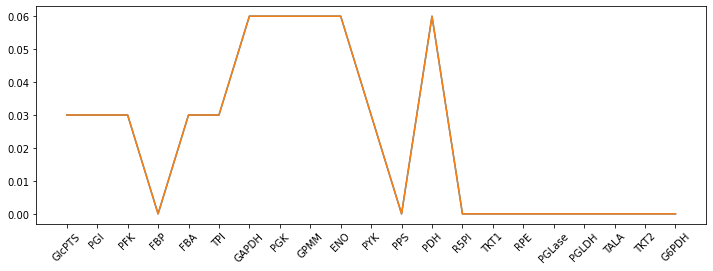

In [35]:
soln = scipy.optimize.least_squares(fun=_loss_jit, args=params, x0=v0[0], jac=_loss_jac, verbose=2)
dmdt = network.s_matrix @ soln.x
print(f"Fit: {sum(float(objectives[name].loss(soln.x, dmdt, None)) for name in ['steady-state', 'irreversibility'])}")
print(soln.x - optimal_array)

fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(np.abs(optimal_array), label='expected')
ax.plot(np.abs(soln.x), label='found')
ax.set_xticks(range(network.shape[1]), labels(network.reactions()), rotation=45)
plt.show()


**Conclusion**
- The graph two cells above highlights the difference between the exclusion objective and blocking FBP and PPS directly. But that difference is actually quite small, < ~0.03%
- The exclusion objective is flexible with respect to overall direction, where blocking specific fluxes would need to know which direction is expected.
- The tradeoff could be well worth it.